In [1]:
import torch
import torch.nn as nn
import cv2
import numpy as np

import os
import matplotlib.pyplot as plt
import time

from collections.abc import Iterable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid

In [18]:
HEIGHT = 320
WIDTH = 200

In [19]:
class ImageDataset(Dataset):

    def __init__(self, path, code=cv2.COLOR_BGR2LAB, transform=transforms.ToTensor()):
        """
        :param path: Path to the image directory location.
        """
        imgs = None
        for folder, sub_folder, filenames in os.walk(path):
            imgs = [cv2.imread(os.path.join(path, file)) for file in filenames]
            imgs = [cv2.cvtColor(img, code) for img in imgs]

        self.imgs = imgs
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, subscript):
        if isinstance(subscript, slice):
            imgs = []
            for img in self.imgs[subscript.start:subscript.stop:subscript.step]:
                img = self.transform(img)
                imgs.append(img)
            return imgs
        else:
            return self.transform(self.imgs[subscript])

    def l_images(self):
        imgs = []
        for img in self.imgs:
            img = self.transform(img)
            imgs.append(img[:1, :, :])
        return imgs

    def ab_images(self):
        imgs = []
        for img in self.imgs:
            img = self.transform(img)
            imgs.append(img[1:, :, :])
        return imgs

#### Custom transformation class to resize images with ```OpenCV``` and later this class instance use with other transformation classes with ```transforms.Compose```.

In [20]:
class OpenCVResize(object):

    def __init__(self, size):
        assert isinstance(size, int) or isinstance(size, Iterable) and len(size) == 2
        self.size = size

    def __call__(self, pic):
        return cv2.resize(np.array(pic), dsize=self.size, interpolation=cv2.INTER_NEAREST)


In [21]:
tf = transforms.Compose({
    OpenCVResize(size=(WIDTH, HEIGHT)),
    transforms.ToTensor()
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
})

gray_dataset = ImageDataset(path='dataset/faces/grayscale', transform=tf, code=cv2.COLOR_BGR2GRAY)
rgb_dataset = ImageDataset(path='dataset/faces/color', transform=tf, code=cv2.COLOR_BGR2RGB)
lab_dataset = ImageDataset(path='dataset/faces/color', transform=tf, code=cv2.COLOR_BGR2LAB)

In [22]:
torch.manual_seed(101)

is_cuda = torch.cuda.is_available()

# GRAYSCALE IMAGES USE TO TRAIN NEURAL NETWORKS.
gray_data_loader = DataLoader(dataset=gray_dataset, batch_size=10, shuffle=True, pin_memory=is_cuda)
rgb_data_loader = DataLoader(dataset=rgb_dataset, batch_size=10, shuffle=False, pin_memory=is_cuda)
# LAB IMAGES FOR VISUALIZATION AND TRAINING PURPOSE.
lab_data_loader = DataLoader(dataset=lab_dataset, batch_size=10, shuffle=False, pin_memory=is_cuda)
l_data_loader = DataLoader(dataset=lab_dataset.l_images(), batch_size=10, shuffle=False, pin_memory=is_cuda)
ab_data_loader = DataLoader(dataset=lab_dataset.ab_images(), batch_size=10, shuffle=False ,pin_memory=is_cuda)

#### View a single batch grayscale and colored image sample.

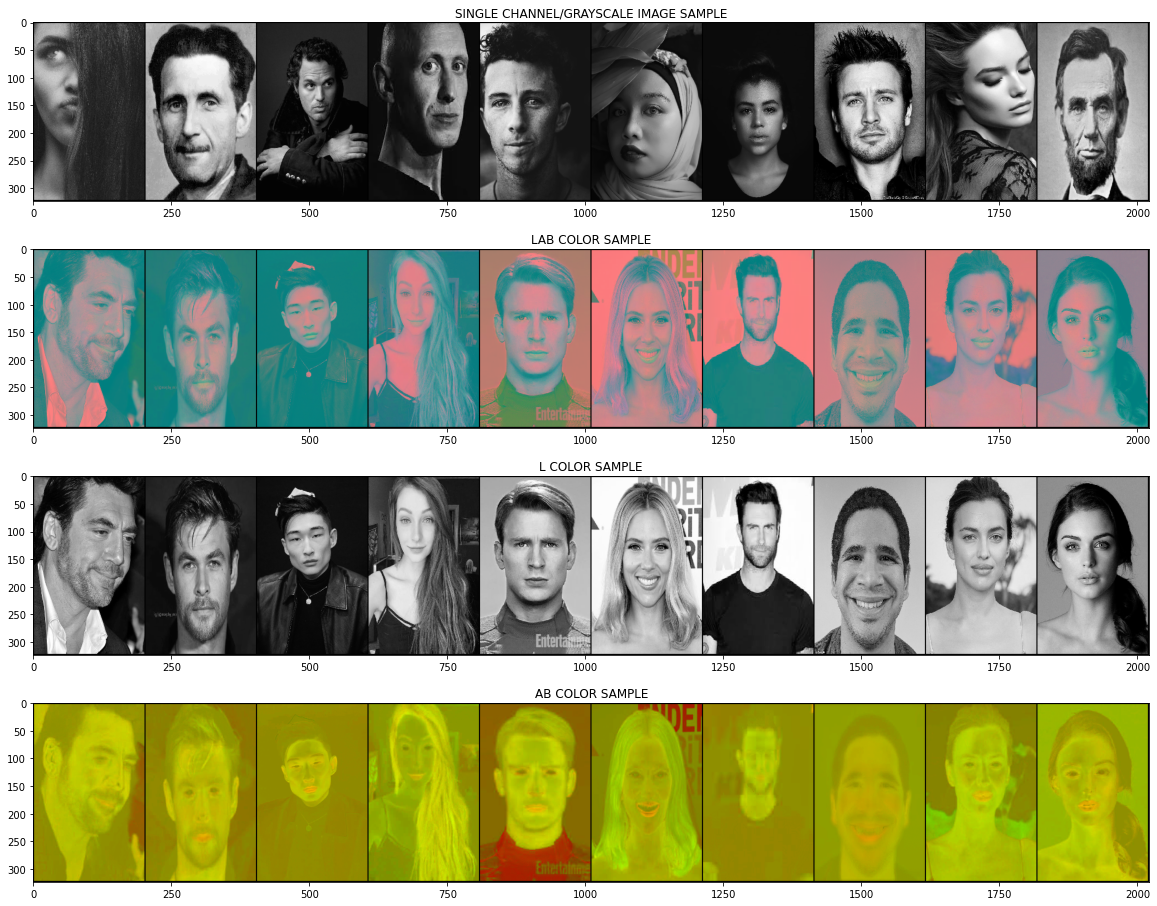

In [23]:
g_ims, l_ims, ab_ims, lab_ims, rgb_ims = (None, None, None, None, None)
for g_ims in gray_data_loader:
    break

for l_ims in l_data_loader:
    break

for ab_ims in ab_data_loader:
    break

for lab_ims in lab_data_loader:
    break

for rgb_ims in rgb_data_loader:
    break

plt.figure(figsize=(20,16))

im = make_grid(g_ims, nrow=10, normalize=True)

plt.subplot(411)
plt.imshow(np.transpose(im, axes=(1, 2, 0)))
plt.title("SINGLE CHANNEL/GRAYSCALE IMAGE SAMPLE")

im = make_grid(lab_ims, nrow=10, normalize=True)

plt.subplot(412)
plt.imshow(np.transpose(im, axes=(1, 2, 0)))
plt.title("LAB COLOR SAMPLE")

im = make_grid(l_ims, nrow=10, normalize=True)

plt.subplot(413)
plt.imshow(np.transpose(im, (1, 2, 0)))
plt.title("L COLOR SAMPLE")

im = make_grid(ab_ims, nrow=10, normalize=True)
im = np.stack([im[0], im[1], np.zeros((im.shape[1], im.shape[2]))])

plt.subplot(414)
plt.imshow(np.transpose(im, (1, 2, 0)))
plt.title('AB COLOR SAMPLE')

plt.show()

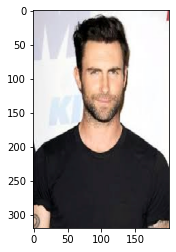

In [24]:
stack = np.stack([l_ims[6][0], ab_ims[6, 0], ab_ims[6, 1]], axis=0)
stack *= 255

stack = np.transpose(stack, (1, 2, 0)).astype(np.uint8)
stack = cv2.cvtColor(stack, code=cv2.COLOR_LAB2RGB)

plt.imshow(stack)

In [25]:
device = torch.device('cuda' if is_cuda else 'cpu')
device

device(type='cuda')

####  Convolutional Neural Network Model

In [26]:
class RGBNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=2, n_layers=(512, 128, 32, 16, 4)):
        super().__init__()

        layers = []

        for i, nl in enumerate(n_layers):
            i += 1

            layers.append(nn.Conv2d(in_channels=in_channels,
                                    out_channels=nl,
                                    kernel_size=3,
                                    stride=1,
                                    padding=1))
            layers.append(nn.BatchNorm2d(nl))
            layers.append(nn.ReLU())

            if i % 2 == 0:
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
                layers.append(nn.Upsample(scale_factor=2))

            in_channels = nl

        layers.append(nn.Conv2d(in_channels=in_channels,
                                out_channels=out_channels,
                                kernel_size=3,
                                stride=1,
                                padding=1))

        self.sequence = nn.Sequential(*layers)

    def forward(self, X):
        return self.sequence(X)


model = RGBNet()

if is_cuda:
  model = model.cuda()
model

RGBNet(
  (sequence): Sequential(
    (0): Conv2d(1, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(512, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Upsample(scale_factor=2.0, mode=nearest)
    (8): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Upsample

In [27]:
count = 0
for params in model.parameters():
  count += params.numel()

count

638630

#### Training Neural Network Models


In [28]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [29]:
epoch = 5
losses = []

start = time.time()

for i in range(epoch):
    i += 1

    batch_time = time.time()

    for batch, (X, y) in enumerate(zip(l_data_loader, ab_data_loader)):
        batch += 1

        X = X.to(device)
        y = y.to(device)

        y_pred = model(X)
        loss = criterion(y_pred, y)

        losses.append(loss)

        if batch % 5 == 0 or batch == 1:
            print(f'Epoch: {i}, Batch: {batch} -> Loss: {loss}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

duration = time.time() - start
print(f'Duration to total execution: {duration / 60:.2f} minutes')

Epoch: 1, Batch: 1 -> Loss: 0.48621034622192383
Epoch: 1, Batch: 5 -> Loss: 0.29952406883239746
Epoch: 1, Batch: 10 -> Loss: 0.20669086277484894
Epoch: 1, Batch: 15 -> Loss: 0.1581021398305893
Epoch: 1, Batch: 20 -> Loss: 0.11960841715335846
Epoch: 2, Batch: 1 -> Loss: 0.1055501401424408
Epoch: 2, Batch: 5 -> Loss: 0.08331942558288574
Epoch: 2, Batch: 10 -> Loss: 0.06210751831531525
Epoch: 2, Batch: 15 -> Loss: 0.047161661088466644
Epoch: 2, Batch: 20 -> Loss: 0.035655535757541656
Epoch: 3, Batch: 1 -> Loss: 0.030105194076895714
Epoch: 3, Batch: 5 -> Loss: 0.02471834607422352
Epoch: 3, Batch: 10 -> Loss: 0.017223671078681946
Epoch: 3, Batch: 15 -> Loss: 0.01176722813397646
Epoch: 3, Batch: 20 -> Loss: 0.010174629278481007
Epoch: 4, Batch: 1 -> Loss: 0.008594518527388573
Epoch: 4, Batch: 5 -> Loss: 0.006302448455244303
Epoch: 4, Batch: 10 -> Loss: 0.005640032235532999
Epoch: 4, Batch: 15 -> Loss: 0.004614843986928463
Epoch: 4, Batch: 20 -> Loss: 0.0059885564260184765
Epoch: 5, Batch: 1 

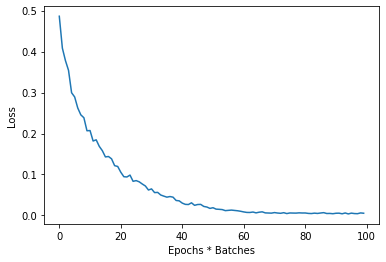

In [30]:
plt.plot(losses)
plt.xlabel('Epochs * Batches')
plt.ylabel('Loss')

del losses

#### Validate images with same dataset used to train.

In [31]:
@torch.no_grad()
def validate(img):

    model.eval()

    ab = model(img.to(device))

    lab = np.stack([img[0, 0], ab.cpu()[0, 0], ab.cpu()[0, 1]], axis=0) * 255

    lab = np.transpose(lab, axes=(1, 2, 0)).astype(np.uint8)
    lab = cv2.cvtColor(lab, code=cv2.COLOR_LAB2RGB)

    plt.imshow(lab)

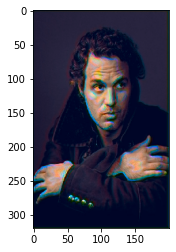

In [39]:
validate(g_ims[2].view(-1, 1, HEIGHT, WIDTH))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.9843) tensor(-0.7529)


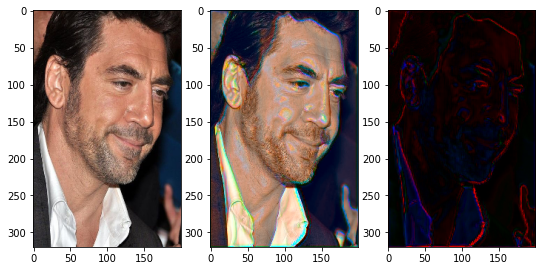

In [33]:
IMG_INDEX = 0

with torch.no_grad():

    model.eval()

    plt.figure(figsize=(9, 8))
    plt.subplot(131)
    plt.imshow(np.transpose(rgb_ims[IMG_INDEX], axes=(1, 2, 0)))

    s = model(l_ims[IMG_INDEX].to(device).view(-1, 1, HEIGHT, WIDTH))
    s = torch.stack([l_ims[IMG_INDEX][0], s[0, 0].cpu(), s[0, 1].cpu()]) * 255
    s = np.transpose(s.detach().view(-1, HEIGHT, WIDTH).numpy(), axes=(1, 2, 0)).astype(np.uint8)
    s = cv2.cvtColor(s, code=cv2.COLOR_LAB2RGB)

    plt.subplot(132)
    plt.imshow(s)

    org = np.transpose(rgb_ims[IMG_INDEX], axes=(1, 2, 0))
    pred = torch.Tensor(s) / 255

    diff = torch.sub(input=org, other=pred)

    print(diff[:, :, 2].max(), diff[:, :, 2].min())

    plt.subplot(133)
    plt.imshow(diff)